# How to save and restart a WorkTree

## Introduction
`WorkTree` supports save and load a WorkTree and modify the workflow, then submit the job again. WorkTree save its data as a extra attribute into its process, so that one can rebuild the WorkTree from the process.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='10014391ebf5492db57a6edfea62c68e' name='default'>

## Create a WorkTree

In [18]:
from aiida_worktree import node
from aiida.engine import calcfunction

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

from aiida_worktree import WorkTree
from aiida.orm import Int
x = Int(2.0)
y = Int(3.0)
z = Int(4.0)

wt = WorkTree("first_workflow")
wt.nodes.new(add, name="add1", x=x, y=y)
wt.nodes.new(add, name="add2", x=x, y=y)
wt.nodes.new(add, name="add3", x=x, y=y)
wt.links.new(wt.nodes["add1"].outputs[0], wt.nodes["add2"].inputs["x"])
wt.links.new(wt.nodes["add2"].outputs[0], wt.nodes["add3"].inputs["x"])

wt.submit(wait=True)

WorkTree node crated, PK: 5828
exist_in_db: False


Check the state and pk of the worktree:

In [19]:
!verdi process status {wt.process.pk}
print('Result of add3      : {}'.format(wt.nodes["add3"].node.outputs.result.value))


WorkTree: first_workflow<5828> Finished [0]
    ├── add<5829> Finished [0]
    ├── add<5831> Finished [0]
    └── add<5833> Finished [0]
Result of add3      : 11


## Load the WorkTree and restart
Now, we modify the `add2` node, and re-submit the worktree. Use the `load` method to load a WorkTree from a process, then use the `restart` flag to restart the workflow

In [20]:
from aiida_worktree import WorkTree
wt2 = WorkTree.load(wt.pk)
wt2.name = "restart_workflow"
wt2.nodes["add2"].set({"y": Int(10).store()})
# use the `restart` flag to restart the workflow
wt2.submit(wait=True, restart=True)

WorkTree node crated, PK: 5836
exist_in_db: False
key y changes
modified_nodes: {'add2'}


### Check status and results
Since we only modify the `add2` node, so the `add2` and its child node `add3` will re-run.

In [21]:
!verdi process status {wt2.process.pk}
print('Result of add3      : {}'.format(wt2.nodes["add3"].node.outputs.result.value))


WorkTree: restart_workflow<5836> Finished [0]
    ├── add<5837> Finished [0]
    └── add<5839> Finished [0]
Result of add3      : 18


Generate node graph from the AiiDA process:

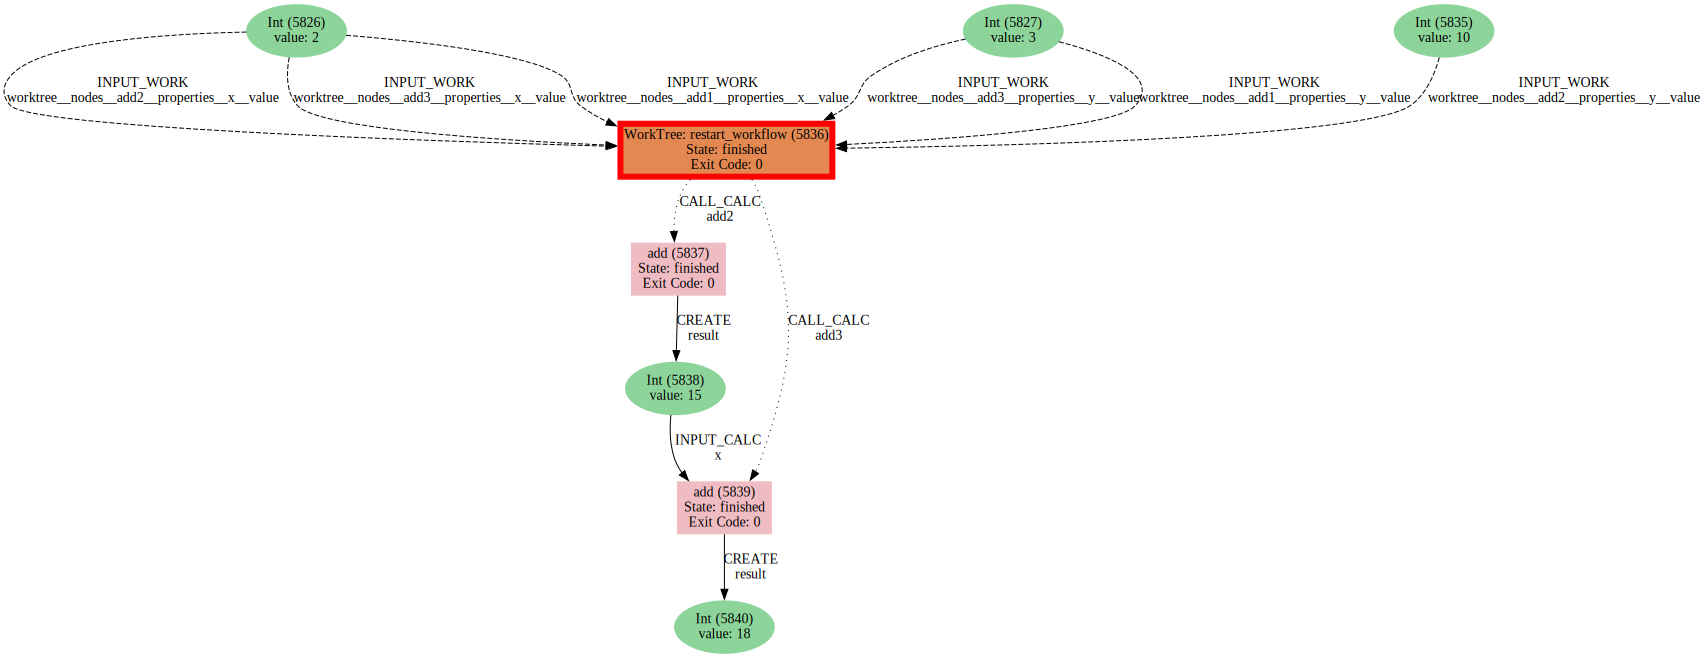

In [22]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt2.pk)